# Fast-Higashi on Dip-C Tan et al. Cell mousebrain dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_dipc_Tan_mousebrain_500k.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommend to be False
                      do_rwr=False, # For high-cov data, the differences are minor, will show later with do_rwr=True option
                      do_col=False,
                      no_col=False)


setting to gpu:7


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/1954 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 72.79 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=False) # we don't have batch_id provided so, set as False
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 1954 bad 0 total: 1954
cache file = /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl


packing sparse mtx into sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/19 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.05066675904989767
do_conv False do_rwr False do_col False
recommend_bs_cell [1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954] pinning memory
packing sparse mtx takes: 28.50 s


In [6]:
wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4 # In the original manuscript, we use this tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. Will do an ablation later
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 0.01


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
time elapsed: 14.47
finish init
Starting iteration 0

PARAFAC2 re=5.674 takes 6.9s
Starting iteration 1

PARAFAC2 re=0.340 9.96e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 6.7s
Starting iteration 2

PARAFAC2 re=0.326 8.24e-02 variation min5.5e-02 at chrom 9, max1.0e-01 at chrom 0 takes 7.3s
Starting iteration 3

PARAFAC2 re=0.314 7.10e-02 variation min5.9e-02 at chrom 10, max8.7e-02 at chrom 7 takes 6.9s
Starting iteration 4

PARAFAC2 re=0.311 2.36e-02 variation min1.9e-02 at chrom 18, max3.2e-02 at chrom 9 takes 7.1s
Starting iteration 5

PARAFAC2 re=0.309 1.00e-02 variation min5.7e-03 at chrom 18, max1.6e-02 at chrom 9 takes 6.6s
Starting iteration 6

PARAFAC2 re=0.308 5.21e-03 variation min2.4e-03 at chrom 18, max8.8e-03 at chrom 9 takes 6.9s
Starting iteration 7

PARAFAC2 re=0.308 3.15e-03 variation min1.4e-03 at chrom 18, max5.1e-03 at chrom 9 takes 6.8s
Starting iteration 8

PARAFAC2 re=0.307 2.11e-03 variat

In [7]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
# The returned embed is a dictionary that stores the embeddings after different ways of post-processing.
# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())



dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


Index(['level_0', 'index', 'cell', 'tissue', 'treatment', 'age', 'sex',
       'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'reads',
       'read length (bp)', 'raw throughput (Gb)', 'raw contacts',
       'raw intra (%)', 'dup rate (%)', 'contacts', 'intra (%)',
       'phased legs (%)', 'raw contacts per read (%)', '20kb RMS RMSD',
       'new cluster', 'new age', 'coverage_fh'],
      dtype='object')


2022-11-28 20:28:08.214887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


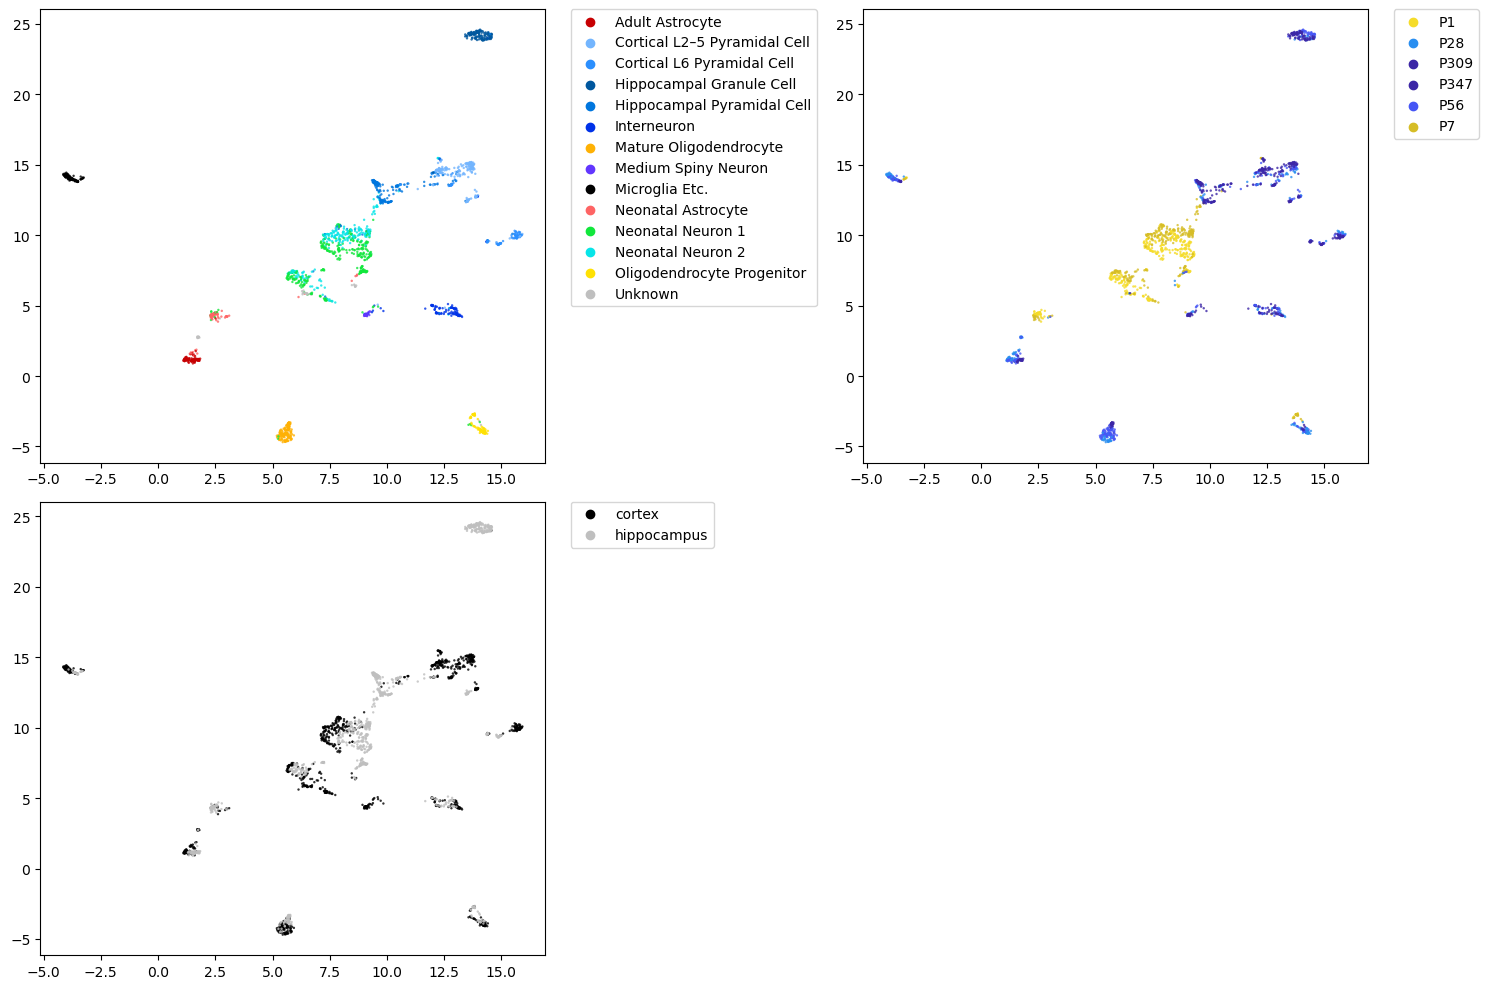

In [8]:
# Check available label information
print (wrapper.label_info.columns)
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()




In [9]:
wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=2e-5, # OK, let's confirm my earlier claim
                  run_init=False # skip initializing the model, but continue training
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
Starting iteration 0

PARAFAC2 re=0.306 takes 7.1s
Starting iteration 1

PARAFAC2 re=0.306 1.91e-04 variation min9.2e-05 at chrom 18, max2.9e-04 at chrom 13 takes 6.7s
Starting iteration 2

PARAFAC2 re=0.306 1.74e-04 variation min9.1e-05 at chrom 18, max2.4e-04 at chrom 3 takes 6.9s
Starting iteration 3

PARAFAC2 re=0.306 1.65e-04 variation min8.8e-05 at chrom 18, max2.2e-04 at chrom 3 takes 7.0s
Starting iteration 4

PARAFAC2 re=0.306 1.55e-04 variation min8.2e-05 at chrom 16, max2.1e-04 at chrom 3 takes 7.0s
Starting iteration 5

PARAFAC2 re=0.306 1.49e-04 variation min7.7e-05 at chrom 16, max2.1e-04 at chrom 13 takes 6.7s
Starting iteration 6

PARAFAC2 re=0.306 1.37e-04 variation min7.3e-05 at chrom 16, max1.8e-04 at chrom 3 takes 7.0s
Starting iteration 7

PARAFAC2 re=0.306 1.34e-04 variation min6.6e-05 at chrom 16, max2.0e-04 at chrom 13 takes 6.9s
Starting iteration 8

PARAFAC2 re=0.306 1.25e-04 variation min6.2e-05 at chrom 16, max1.6


PARAFAC2 re=0.305 2.77e-05 variation min-1.5e-05 at chrom 13, max4.0e-05 at chrom 3 takes 7.5s
Starting iteration 71

PARAFAC2 re=0.305 3.13e-05 variation min1.6e-05 at chrom 18, max4.4e-05 at chrom 13 takes 7.6s
Starting iteration 72

PARAFAC2 re=0.305 2.99e-05 variation min1.9e-05 at chrom 8, max4.2e-05 at chrom 15 takes 7.5s
Starting iteration 73

PARAFAC2 re=0.305 3.03e-05 variation min1.4e-05 at chrom 18, max4.0e-05 at chrom 15 takes 7.5s
converged in 73 iterations.
start transform
takes: 527.38 s


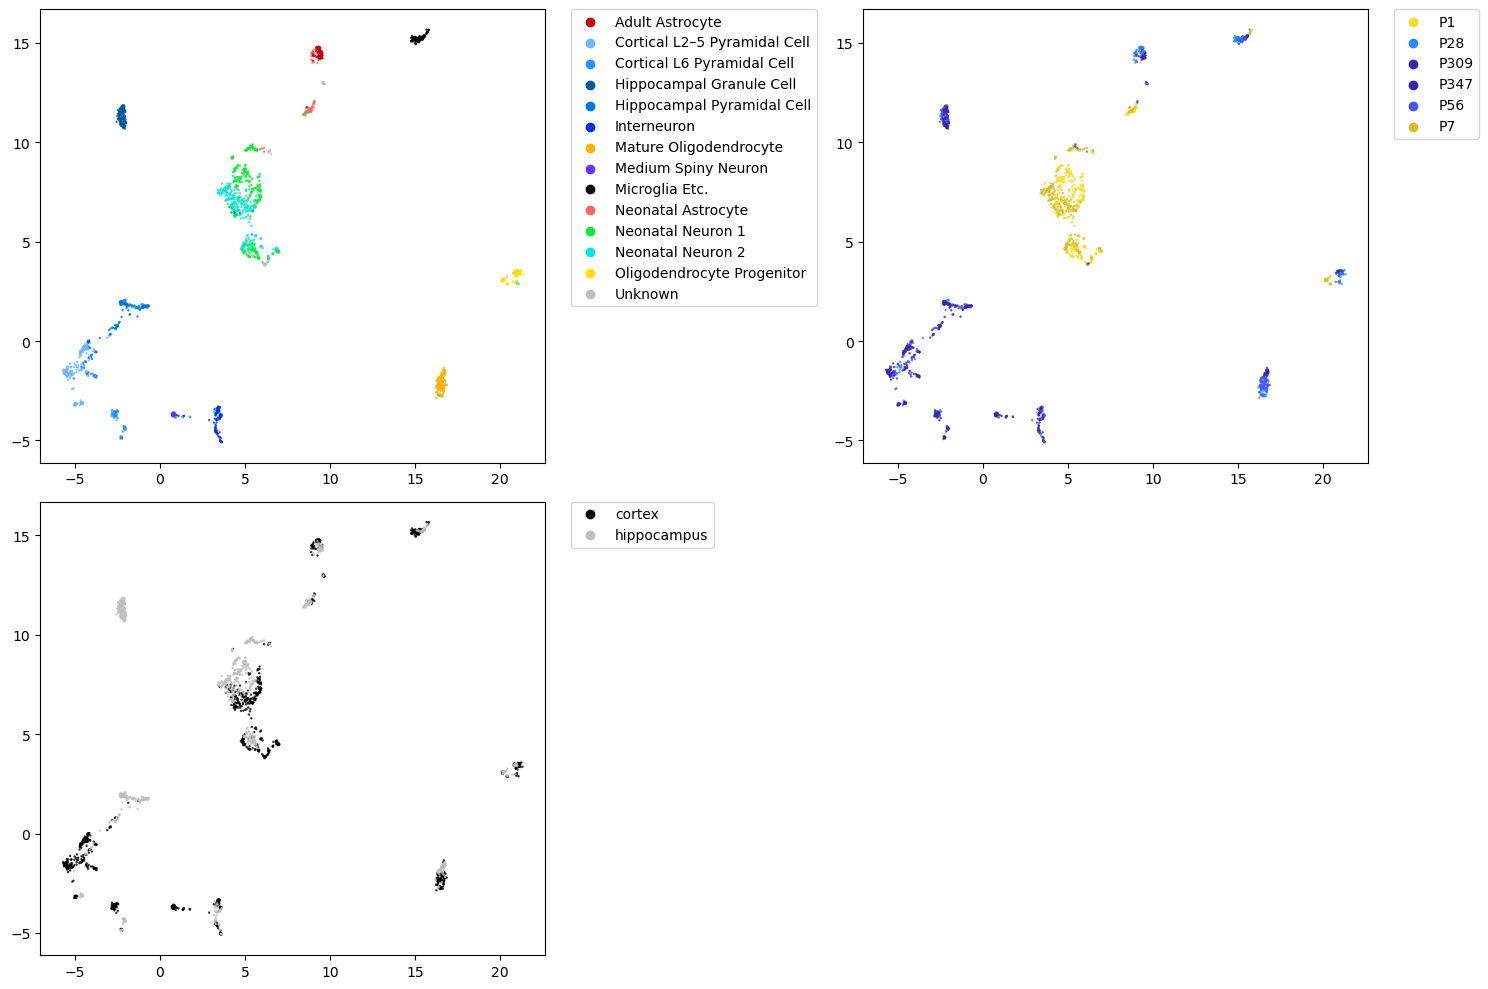

In [10]:
# For this dataset, changing tol wouldn't affect results that much.

embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()

setting to gpu:1
total number of cells that pass qc check 1954 bad 0 total: 1954
cache file = /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
loading cached input from /home/rzhang/Higashi/Temp/dipc_Tan_mousebrain_500k/cache_intra_500000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.05066675904989767
do_conv False do_rwr True do_col False
recommend_bs_cell [1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954, 1954] pinning memory
dim1_0.6_rank_256_niterp_1_
n_iter_parafac 1
time elapsed: 1.39


initializing params:   0%|          | 0/19 [00:00<?, ?it/s]

rwr iters: [5 5 5 5 5 5 5 5 5 5 5 5 5 6 5 5 5 5 5]
time elapsed: 33.15
finish init
Starting iteration 0

PARAFAC2 re=5.910 takes 6.6s
Starting iteration 1

PARAFAC2 re=0.372 9.96e-01 variation min9.9e-01 at chrom 18, max1.0e+00 at chrom 0 takes 6.7s
Starting iteration 2

PARAFAC2 re=0.360 6.69e-02 variation min4.6e-02 at chrom 13, max8.5e-02 at chrom 3 takes 6.9s
Starting iteration 3

PARAFAC2 re=0.347 7.00e-02 variation min5.2e-02 at chrom 10, max8.0e-02 at chrom 9 takes 6.8s
Starting iteration 4

PARAFAC2 re=0.343 2.26e-02 variation min1.9e-02 at chrom 18, max3.3e-02 at chrom 1 takes 6.8s
Starting iteration 5

PARAFAC2 re=0.341 9.12e-03 variation min6.1e-03 at chrom 18, max1.5e-02 at chrom 7 takes 6.9s
Starting iteration 6

PARAFAC2 re=0.341 4.68e-03 variation min2.6e-03 at chrom 18, max8.6e-03 at chrom 7 takes 6.8s
Starting iteration 7

PARAFAC2 re=0.340 2.87e-03 variation min1.5e-03 at chrom 18, max5.3e-03 at chrom 7 takes 6.8s
Starting iteration 8

PARAFAC2 re=0.340 1.97e-03 varia

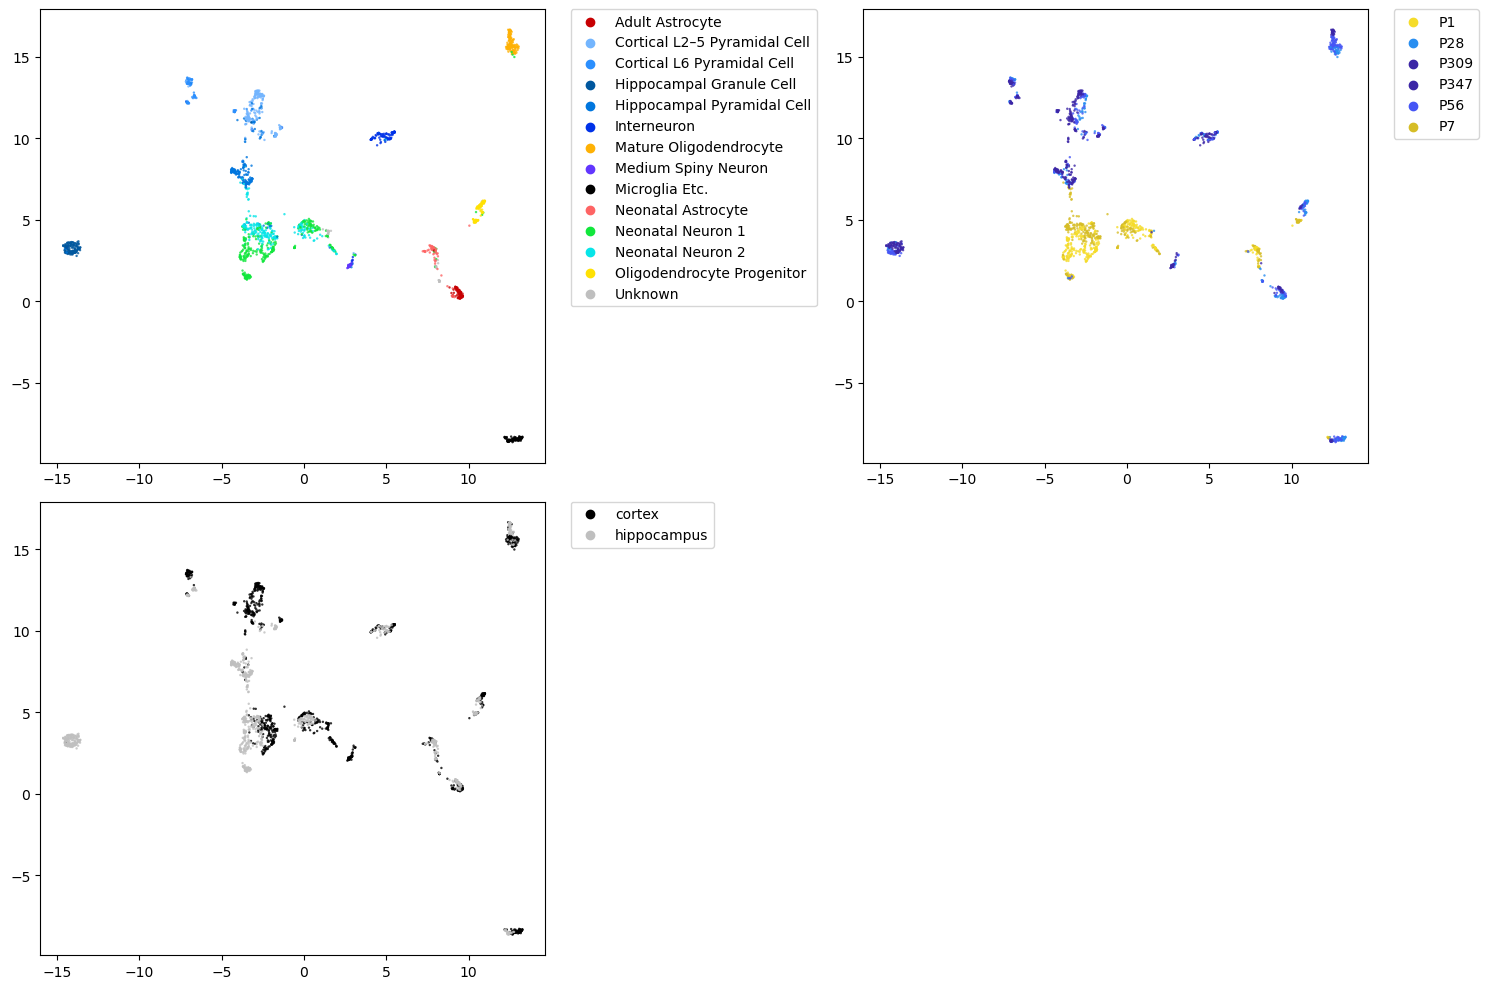

In [11]:
# Now let's validate that run with do_rwr would lead to minor change here:

wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=False, # at coarser resolution for high cov data, recommende to be False
                      do_rwr=True,
                      do_col=False,
                      no_col=False)
# The packed sparse tensor is cached,it will be loaded very fast
start = time.time()
wrapper.prep_dataset(batch_norm=False)

wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=256,
                  n_iter_parafac=1,
                  tol=3e-4 # In the original manuscript, we use this tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. Will do an ablation later
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=256,
                   n_iter_parafac=1
                   )

embed = wrapper.fetch_cell_embedding(final_dim=256,
                                     restore_order=False)
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0).fit_transform(embedding)
# pull the visualization palette from the config file
vis_palette = wrapper.config['vis_palette']


fig = plt.figure(figsize=(15, 10))
for col_index, col in enumerate(["cell-type cluster", "age", "tissue"]):
    ax = plt.subplot(2, 2, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], ax=ax, s=3, alpha=0.8, linewidth=0, palette=vis_palette[col])
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.tight_layout()
plt.show()